In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Change later : Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

## Machine learning

In [5]:
from implementations import *

### Data pre-processing 

In [6]:
# putting the meaningless values to the median of the column
tX = np.where(tX==-999., np.nan,tX)
med_X = np.nanmedian(tX, axis=0)

inds = np.where(np.isnan(tX))
tX[inds] = np.take(med_X, inds[1])

In [7]:
print(np.where(tX[0] == 2))

(array([22], dtype=int64),)


In [9]:
# remove categorical data and standarize the rest
tX = np.delete(tX, 22, axis=1)
tX = np.apply_along_axis(standardize, 1, tX)

#ny = y[0:25000]
#ntX = ntX[0:25000, :]

### Exploratory analysis

### Feature processing

**Least squares**

In [11]:
(w_ls, loss_ls) = least_squares(y, tX)

print("w* ={w}\n\nmse={loss}".format(
    w=w_ls, loss=loss_ls))

w* =[ 4.82051822e+00  4.27772865e+00  4.24767828e+00  4.83851856e+00
 -1.47600577e+01  4.99423023e+00  4.32542893e+00  2.50425419e+01
  4.68691015e+00  1.02934762e+01 -1.17318929e+01  8.84241821e+00
  2.85008076e+01 -6.63855780e-03  4.79829573e+00  4.76317674e+00
  2.07077470e-01  4.78759667e+00  4.86542406e+00  4.99168786e+00
  4.78602323e+00  4.73264621e+00  4.78579558e+00  4.73967253e+00
  3.51715147e+00  4.87750359e+00  4.57743636e+00 -7.29805428e-01]

mse=0.3341143816880321


**Least squares with Gradient Descent**

In [12]:
#define parameters

initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_gd = []
ws_gd = []
for gamma in gammas:
    (w, loss) = least_squares_GD(y, tX, initial_w, max_iters, gamma)
    losses_gd.append(loss)
    ws_gd.append(w)

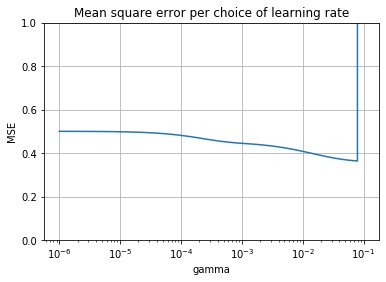

In [13]:
#plot the losses per gamma

fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [14]:
idx = np.argmin(losses_gd)

loss_gd = losses_gd[idx]
w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=loss_gd, gamma=gamma_gd ))

w* =[ 0.02733391 -0.5502938  -0.03999321  0.1232555   0.03395028  0.06393681
  0.03024024  0.03667066 -0.04790054  0.05051551  0.02226379  0.05174338
  0.03660991  0.25531622  0.03652133  0.03564291 -0.0917335   0.03668701
  0.03727244 -0.07412236  0.03710573 -0.06396616  0.0365915   0.03667982
 -0.1536225   0.03669963  0.03639934 -0.03980383]

mse=0.36322939070678123

gamma=0.07906043210907701


**Least squares with Stochastic Gradient Descent**

In [12]:
initial_w = np.zeros(ntX.shape[1])
max_iters = 100
gammas = np.logspace(-6, -1, 50)

losses_sgd = []
ws_sgd = []
for gamma in gammas:
    (w, loss) = least_squares_SGD(y, tX, initial_w, max_iters, gamma)
    losses_sgd.append(loss)
    ws_sgd.append(w)

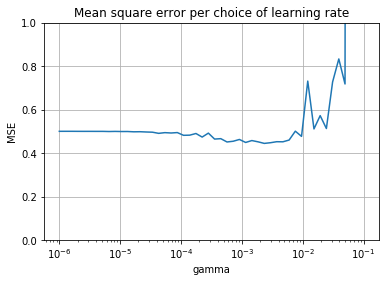

In [13]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [14]:
idx = np.argmin(losses_sgd)

loss_sgd = losses_sgd[idx]
w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=ws_sgd[-1], loss=loss_sgd, gamma = gamma_sgd))

w* =[ 163149.5350031   -19700.56250131  135290.06289376  -33509.02310371
    3485.31543425 -121954.17960975    3525.04730295    5265.30945006
   34511.13085635  -30690.71821815    3518.30276885    3909.1862154
    3559.94655612   22054.28921623    3062.42833885    1614.82418278
    8553.76104028    5633.83655098    5787.81754312  -21766.75521745
    -987.37389364  -93222.40591494  -31912.19307367    4909.76077413
    1413.32498037   -8611.05224791    3482.89810774    3917.16243895
  -54289.67587374]

mse=0.4442784580532515

gamma=0.002329951810515372


**Ridge regression**

***Cross-validation hyperparameter selection***

In [15]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("rmse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)

In [16]:
seed = 1
degree = 2
k_fold = 4
lambdas = np.logspace(-15, -1, 50)

In [18]:
k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_cv = []
rmse_te_cv = []

for lambda_ in  lambdas:
    l_rmse_tr = []
    l_rmse_te = []
    for k in range(k_fold):
        loss_tr, loss_te = cross_validation(y, tX, k_indices, k, lambda_, degree)
        l_rmse_tr.append(np.sqrt(2*loss_tr))
        l_rmse_te.append(np.sqrt(2*loss_te))
    rmse_tr_cv.append(np.mean(l_rmse_tr))
    rmse_te_cv.append(np.mean(l_rmse_te))
cross_validation_visualization(lambdas, rmse_tr_cv, rmse_te_cv)

KeyboardInterrupt: 

In [ ]:
idx = np.argmin(rmse_te_cv)
lambda_ri = lambdas[idx]

print("lambda* ={lambda_}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    lambda_=lambda_ri, rmse_tr=rmse_tr_cv[idx], rmse_te=rmse_te_cv[idx]))

***Bias-variance decomposition for complexity determination***

In [45]:
def bias_variance_decomposition_visualization(degrees, rmse_tr, rmse_te):
    """visualize the bias variance decomposition."""
    rmse_tr_mean = np.expand_dims(np.mean(rmse_tr, axis=0), axis=0)
    rmse_te_mean = np.expand_dims(np.mean(rmse_te, axis=0), axis=0)
    plt.plot(degrees, rmse_tr.T, 'b', linestyle="-",
        label='train', linewidth=0.3)
    plt.plot(degrees, rmse_te.T, 'r', linestyle="-", label='test', linewidth=0.3)
    plt.plot(degrees, rmse_tr_mean.T, 'b', linestyle="-", label='train', linewidth=3)
    plt.plot(degrees, rmse_te_mean.T, 'r', linestyle="-", label='test', linewidth=3)
    plt.ylim(0, 5)
    plt.xlabel("degree")
    plt.ylabel("error")
    plt.title("Bias-Variance Decomposition")

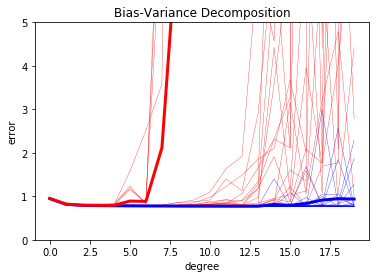

In [47]:
seeds = range(20)
ratio_train = 0.7
degrees = range(0, 20)


rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)        
        
    mse_tr = []
    mse_te = []
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_tr))
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*np.array(mse_te))

bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

In [37]:
idx = np.argmin(rmse_te_cv.mean()-rmse_tr_cv.mean())

degree_ri = degrees[idx]

print("degree* ={dergee}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}".format(
    degree=degree_ri, rmse_tr=rmse_tr_bv[idx], rmse_te=rmse_te_bv[idx]))

IndexError: range object index out of range

**Logistic regression**

### Overfitting vs Underfitting

### Methods application and visualization

## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)